In [1]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [2]:
n_categories = 3
all_categories =  [('H', 'G', 'I' ), 
                   ('E','B'), 
                   ('S','T','C','-')]

all_letters = ['_','C', 'V', 'T', 'F', 'Y', 'A', 'P', 'W', 'I', 'M', 'L', 'S', 'G', 'H', 'D', 'E', 'N', 'Q', 'R', 'K']
n_letters = len(all_letters)
char_to_int = dict((c, i) for i, c in enumerate(all_letters))

int_to_char = dict((c, i) for i, c in char_to_int.items())
#print(n_chars)


# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.index(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.index(line[li]) for li in range(1, len(line))]
    letter_indexes.append( all_letters.index('_' )) # EOS
    return torch.LongTensor(letter_indexes)

In [3]:
import pickle
import random

In [4]:
dataset = pickle.load(open('./20180609-3Q_len10.pkl','rb'))

In [5]:
random.seed = 42

In [6]:
training= list()

for c in all_categories:
    random.shuffle(dataset[c] )
    for i in range(20000):
        try:
            cate = categoryTensor(c).cuda()
            itensor = inputTensor(dataset[c][i]).cuda()
            ttensor = targetTensor(dataset[c][i]).cuda()
            training.append([cate, itensor, ttensor ])
        except ValueError:
            pass

In [7]:
criterion = nn.NLLLoss()

learning_rate = 0.0001

def train(category_tensor, input_line_tensor, target_line_tensor):
    target = target_line_tensor.clone()
    target = target.unsqueeze_(-1)
    hidden = rnn.initHidden().cuda()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        #print(i)
        l = criterion(output, target[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [8]:
random.shuffle(training)

In [11]:
rnn = RNN(n_letters, 256, n_letters).cuda()

n_iters = len(training)
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

#start = time.time()

for idx,item in enumerate(training):
    #print(item)
    output, loss = train(item[0],item[1],item[2])
    total_loss += loss

    if idx % print_every == 0:
        print('(%d %d%%) %.4f' % ( idx, idx / n_iters * 100, loss))

    if idx % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

(0 0%) 3.0432
(5000 8%) 2.8605
(10000 16%) 2.9566
(15000 25%) 2.6400
(20000 33%) 2.9212
(25000 41%) 2.6808
(30000 50%) 2.4905
(35000 58%) 2.7767
(40000 66%) 2.5985
(45000 75%) 2.5732
(50000 83%) 2.6380
(55000 91%) 2.7159


In [12]:
%matplotlib inline

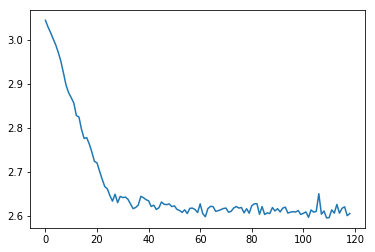

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses[1:])

In [18]:
for e in range(5):
    for idx,item in enumerate(training):
        #print(item)
        output, loss = train(item[0],item[1],item[2])
        total_loss += loss

        if idx % print_every == 0:
            print('(%d %d%%) %.4f' % ( idx, idx / n_iters * 100, loss))

        if idx % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0

(0 0%) 2.3870
(5000 8%) 2.6152
(10000 16%) 2.6670
(15000 25%) 2.5129
(20000 33%) 2.7249
(25000 41%) 2.5919
(30000 50%) 2.7963
(35000 58%) 2.6307
(40000 66%) 2.6485
(45000 75%) 2.7574
(50000 83%) 2.5850
(55000 91%) 2.4608
(0 0%) 2.4056
(5000 8%) 2.5881
(10000 16%) 2.5435
(15000 25%) 2.5212
(20000 33%) 2.8779
(25000 41%) 2.6066
(30000 50%) 2.5965
(35000 58%) 2.5564
(40000 66%) 2.5265
(45000 75%) 2.4457
(50000 83%) 2.6546
(55000 91%) 2.4174
(0 0%) 2.3828
(5000 8%) 2.5662
(10000 16%) 2.5937
(15000 25%) 2.5847
(20000 33%) 2.8928
(25000 41%) 2.7397
(30000 50%) 2.7376
(35000 58%) 2.6379
(40000 66%) 2.6364
(45000 75%) 2.5947
(50000 83%) 2.6477
(55000 91%) 2.4414
(0 0%) 2.3898
(5000 8%) 2.6812
(10000 16%) 2.7021
(15000 25%) 2.5732
(20000 33%) 2.7421
(25000 41%) 2.6980
(30000 50%) 2.6023
(35000 58%) 2.5516
(40000 66%) 2.6536
(45000 75%) 2.5763
(50000 83%) 2.5498
(55000 91%) 2.4372
(0 0%) 2.3184
(5000 8%) 2.5269
(10000 16%) 2.6799
(15000 25%) 2.5664
(20000 33%) 2.8361
(25000 41%) 2.8807
(30000 50

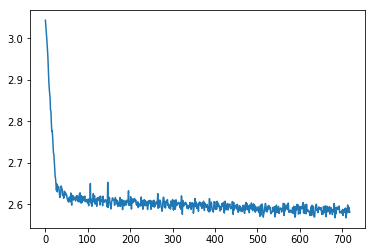

In [19]:
plt.plot(all_losses[1:])

In [20]:
def sample(category, start_letter='A'):
    max_length= 9
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category).cuda()
        input = inputTensor(start_letter).cuda()
        hidden = rnn.initHidden().cuda()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            #if topi == n_letters - 1:
            #    break
            #else:
            letter = all_letters[topi]
            output_name += letter
            input = inputTensor(letter).cuda()

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ACW'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [21]:
samples(('H', 'G', 'I' ))

AEELLELLKE
CEELLELLKE
WELLKALLEL
